In [1]:
import torch
import numpy as np
import time
import math
import matplotlib.pyplot as plt

## GPU

Jednym z kluczowych udogodnień pytorcha jest możliwość szybkiego i prostego przenoszenia obliczeń między CPU a GPU

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda") 
device

device(type='cuda')

In [4]:
x = torch.zeros(2, 3)
print("X", x)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]])
X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


#### Co nam to daje?
+ porównanie mnożenia macierzy 15000x150000

In [67]:
x = torch.randn(15000, 15000)

## CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"CPU time: {(end_time - start_time):6.5f}s")

## GPU version
x = x.to(device)
# The first operation on a CUDA device can be slow as it has to establish a CPU-GPU communication first. 
# Hence, we run an arbitrary command first without timing it for a fair comparison.
_ = torch.matmul(x*0.0, x)
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print(f"GPU time: {(end_time - start_time):6.5f}s")

CPU time: 19.39901s
GPU time: 0.00107s


#### Ciąg komend do zapisania
Losowość jest bardzo ważnym elementem trenowania sieci neuronowych (o czym się wkrótce przekonamy). Eksperymentując, chcielibyśmy jednak żeby przy każdym uruchomieniu programu, wynik był taki sam. Tylko w takim przypadku jesteśmy w stanie coś wnioskować. Do zapewnienia możliwości reprodukcji wyników na GPU za pomocą pytorcha służa poniższe komendy:

In [4]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

## Tworzenie modeli
Tworzymy tensory z parametrami, wagi i biasy, obliczamy gradienty, aktualizujemy parametry itd.
lub
wykorzystujemy torch.nn

W torch.nn możemy znaleźć wiele przydatnych predefiniowanych klas jak wagi sieci, funkcje aktywacji, funkcje straty, optymalizacja itp. Jeszcze raz, dokumentacja jest fajna: https://pytorch.org/docs/stable/nn.html

In [5]:
import torch.nn as nn

Dodatkowo, funkcje wykorzystywane w budowaniu sieci znajdują się w module torch.nn.functionl

In [6]:
import torch.nn.functional as F

### nn.Module
W PyTorchu, sieci neuronowe są zbudowane z modułów - obiektów klas dziedziczących po klasie nn.Module. Moduły mogą składać się z innych modułów, a sieć neuronowa w całości też zazwyczaj jest modułem.

Podstawowy template dla modułu wygląda następująco

In [9]:
class MyModule(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Some init for my module
        
    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

W konstruktorze modułu zazwyczaj inicjowane są wszystkie parametry, lub wewnętrzne moduły (np. warstwy sieci)

W funkcji forward zapisane są wszystkie obliczenia które są wykonywane kiedy wywołujemy dany moduł. Przykładowo: (nn = MyModule(); nn(x)). 

Kalkulacja wstecz (backwards) jest tworzona automatycznie, ale w razie potrzeby można ją też nadpisywać 

# Stwórzmy pierwsza sieć neuronową 

In [53]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

Wypisywanie zawartości modelu

In [11]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


Co tak właściwie mamy w środku?

In [12]:
for name, param in model.named_parameters():
    print(f"Parameter {name}, shape {param.shape}")

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


## Funkcje aktywacji

In [7]:
act_fn_by_name = {
    "sigmoid": torch.sigmoid,
    "tanh": torch.tanh,
    "relu": F.relu,
    "leakyrelu": F.leaky_relu
}

In [9]:
# function returns gradient of x depending of activation function
def get_grads(act_fn, x):
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

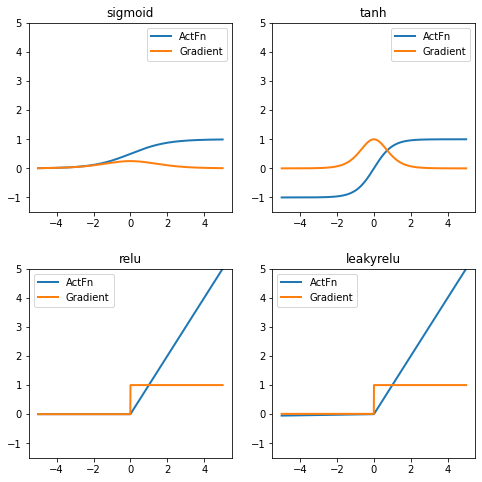

In [10]:
%matplotlib inline
def vis_act_fn(act_fn, name, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fn_by_name)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, name in enumerate(act_fn_by_name.keys()):
    vis_act_fn(act_fn_by_name[name], name, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()
plt.close()

# Dane
PyTorch posiada zaimplementowanych kilka funkcjonalności które pozwalają wczytywać i manipulować danymi. Znajdują się one w pakiecie torch.utils.data

In [8]:
import torch.utils.data as data

Główną strukturą w ramach której przechowywane (lub niekoniecznie) są dane jest klasa Dataset. Stwórzmy sobie przykładowy zbiór danych - tzw. ciągły XOR. Przykład zaczerpnięty z https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html#Learning-by-example:-Continuous-XOR

In [20]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
        # If x=y, the label is 0.
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [21]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([0.0281, 1.2301]), tensor(1))


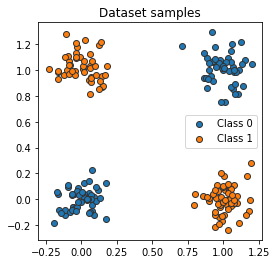

In [25]:
examples = dataset.data
labels = dataset.label
data_0 = examples[labels == 0]
data_1 = examples[labels == 1]

plt.figure(figsize=(4,4))
plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
plt.title("Dataset samples")
plt.legend()
plt.show()

## Data loaders (Ładowacze danych?!)

In [12]:
data_loader = data.DataLoader(dataset,batch_size=8, shuffle=True)

NameError: name 'dataset' is not defined

In [27]:
next(iter(data_loader))

[tensor([[-0.0470,  0.9655],
         [ 0.9006,  0.0103],
         [-0.0910,  0.1092],
         [ 0.9844,  0.0182],
         [ 0.0519,  0.1366],
         [ 0.7948, -0.0460],
         [ 0.9680,  1.0569],
         [-0.0958,  1.1129]]),
 tensor([1, 1, 0, 1, 0, 1, 0, 1])]

In [28]:
len(data_loader)

25

In [31]:
iter(data_loader)

In [32]:
next(iter(data_loader))[0].shape[0]*len(data_loader)

200

In [33]:
data_loader_2 = data.DataLoader(dataset,batch_size=7, shuffle=True)
next(iter(data_loader_2))[0].shape[0]*len(data_loader_2)

203

In [34]:
list(iter(data_loader_2))[-1]

[tensor([[ 0.9612,  0.0646],
         [ 1.0600,  0.0346],
         [ 0.1255,  0.8505],
         [-0.0634, -0.0818]]),
 tensor([1, 1, 1, 0])]

#### Drop last
Parametr powodujący pominięcie ostatniego wsadu (batch)

In [35]:
data_loader_2 = data.DataLoader(dataset,batch_size=7, shuffle=True, drop_last=True)
next(iter(data_loader_2))[0].shape[0]*len(data_loader_2)

196

## Funkcje straty
Na poprzednich zajęciach obliczaliśmy funkcję straty ręcznie wykonując operacje na tensorach. Jest to w pełni poprawne rozwiązanie, ale możemy też nie wymyślać koła na nowo, ale wykorzystać wbudowane moduły. Pełna lista dostępna tutaj: https://pytorch.org/docs/stable/nn.html#loss-functions

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

In [37]:
tensor_1 = torch.arange(5)
tensor_2 = torch.ones(5)
print(tensor_1, tensor_2)

tensor([0, 1, 2, 3, 4]) tensor([1., 1., 1., 1., 1.])


### Błąd średniokwadratowy (Mean Squared Error) lub L2Loss

In [38]:
loss = nn.MSELoss()
loss(tensor_1,tensor_2)

tensor(3.)

$ \quad l_{n}=\left(x_{n}-y_{n}\right)^{2}$

In [39]:
loss = nn.MSELoss(reduction="none")
print(f"No reduction: {loss(tensor_1,tensor_2)}")
loss = nn.MSELoss(reduction="mean")
print(f"Mean: {loss(tensor_1,tensor_2)}")
loss = nn.MSELoss(reduction="sum")
print(f"Sum: {loss(tensor_1,tensor_2)}")

No reduction: tensor([1., 0., 1., 4., 9.])
Mean: 3.0
Sum: 15.0


In [40]:
F.mse_loss(tensor_1, tensor_2)

tensor(3.)

<IPython.core.display.Javascript object>


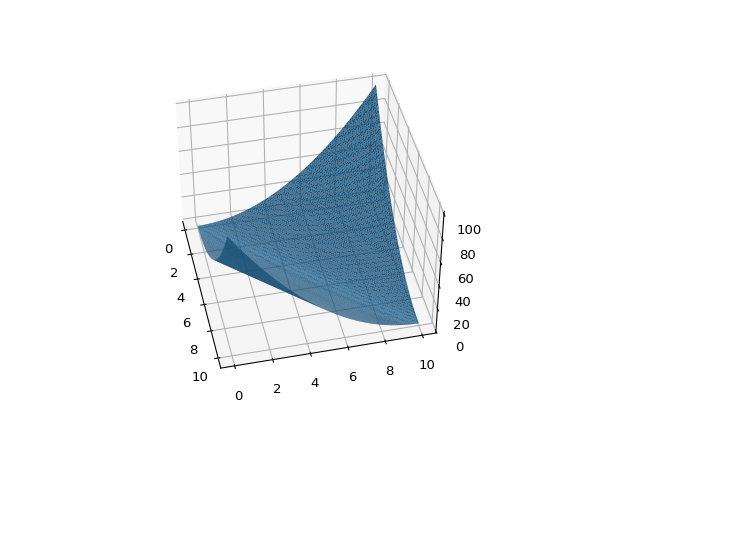

C:\Users\01149762\AppData\Local\Temp/ipykernel_4428/1793820244.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [37]:
loss = nn.MSELoss(reduction="none")
x, y = torch.meshgrid(torch.linspace(0,10,100),torch.linspace(0,10,100))
z = loss(x,y)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(x.numpy().flatten(), y.numpy().flatten(), z.numpy().flatten(), linewidth=0.2, antialiased=True)

plt.show()

### Błąd bezwzględny (Mean absolute Error) lub L1Loss

$ \quad l_{n}=\left|x_{n}-y_{n}\right|$

In [47]:
print(tensor_1, tensor_2)
loss = nn.L1Loss()
tensor_1 = tensor_1.float()
loss(tensor_1,tensor_2)

tensor([0, 1, 2, 3, 4]) tensor([1., 1., 1., 1., 1.])


tensor(1.4000)

In [48]:
loss = nn.L1Loss(reduction="none")
print(f"No reduction: {loss(tensor_1,tensor_2)}")
loss = nn.L1Loss(reduction="mean")
print(f"Mean: {loss(tensor_1,tensor_2)}")
loss = nn.L1Loss(reduction="sum")
print(f"Sum: {loss(tensor_1,tensor_2)}")

No reduction: tensor([1., 0., 1., 2., 3.])
Mean: 1.399999976158142
Sum: 7.0


<IPython.core.display.Javascript object>


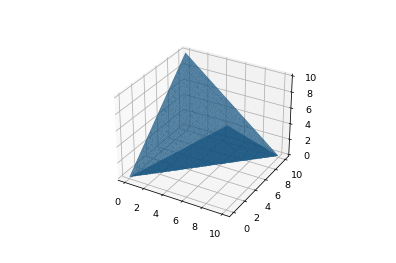

C:\Users\01149762\AppData\Local\Temp/ipykernel_12816/1058480425.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [49]:
loss = nn.L1Loss(reduction="none")
x, y = torch.meshgrid(torch.linspace(0,10,100),torch.linspace(0,10,100))
z = loss(x,y)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(x.numpy().flatten(), y.numpy().flatten(), z.numpy().flatten(), linewidth=0.2, antialiased=True)

plt.show()

### Entropia krzyżowa:
$l_{n}=\left[y_{n} \cdot \log x_{n}+\left(1-y_{n}\right) \cdot \log \left(1-x_{n}\right)\right]$

In [39]:
tensor_1 = torch.rand(5).float()
tensor_2 = torch.ones(5).float()
print(tensor_1, tensor_2)
loss = nn.BCELoss(reduction="none")
loss(tensor_1,tensor_2)

tensor([0.6595, 0.6293, 0.2404, 0.7383, 0.2333]) tensor([1., 1., 1., 1., 1.])


tensor([0.4163, 0.4631, 1.4255, 0.3033, 1.4554])

+ Użycie entropii z BCELoss() nie pozwala na wartości nie należące to (0,1)

In [40]:
loss(tensor_1*10,tensor_2)

RuntimeError: all elements of input should be between 0 and 1

+ ta za to działa

In [41]:
loss = nn.BCEWithLogitsLoss(reduction="none")
loss(tensor_1*10,tensor_2)

tensor([0.0014, 0.0018, 0.0865, 0.0006, 0.0926])

<IPython.core.display.Javascript object>


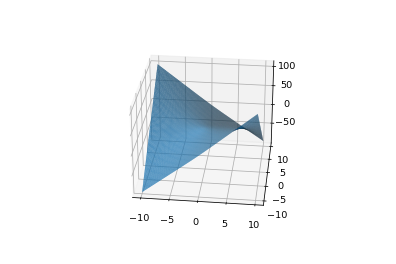

C:\Users\01149762\AppData\Local\Temp/ipykernel_12816/1858135863.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [55]:
loss = nn.BCEWithLogitsLoss(reduction="none")
x, y = torch.meshgrid(torch.linspace(-10,10,100),torch.linspace(-10,10,100))
z = loss(x,y)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(x.numpy().flatten(), y.numpy().flatten(), z.numpy().flatten(), linewidth=0.2, antialiased=True)

plt.show()

# Optymalizacja parametrów
W przykładowym problemie optymalizacji parametrów regresji, ręcznie aktualizowaliśmy gradienty. W torch są do tego narzędzia zwane optymalizatorami, znajdują się one w pakiecie torch.optim

Najprostszym optymalizaotrem jest algorytm stochastycznego spadku gradientu (Stochastic Gradient Descent) - SGD

In [61]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [62]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

## Połączmy to wszystko razem

In [133]:
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [137]:
train_dataset[2]

(tensor([-0.0485,  0.9475]), tensor(1))

In [64]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
model.to(device)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)

In [65]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [66]:
loss_module = nn.BCEWithLogitsLoss()

In [67]:
model.train() 

# Training loop
for epoch in range(100):
    for data_inputs, data_labels in data_loader:

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

        ## Step 3: Calculate the loss
        loss = loss_module(preds, data_labels.float())

        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero. 
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad() 
        # Perform backpropagation
        loss.backward()

        ## Step 5: Update the parameters
        optimizer.step()
    print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 0.661
Epoch: 1, loss: 0.716
Epoch: 2, loss: 0.666
Epoch: 3, loss: 0.684
Epoch: 4, loss: 0.607
Epoch: 5, loss: 0.652
Epoch: 6, loss: 0.622
Epoch: 7, loss: 0.636
Epoch: 8, loss: 0.611
Epoch: 9, loss: 0.561
Epoch: 10, loss: 0.572
Epoch: 11, loss: 0.513
Epoch: 12, loss: 0.572
Epoch: 13, loss: 0.406
Epoch: 14, loss: 0.362
Epoch: 15, loss: 0.527
Epoch: 16, loss: 0.395
Epoch: 17, loss: 0.247
Epoch: 18, loss: 0.313
Epoch: 19, loss: 0.256
Epoch: 20, loss: 0.23
Epoch: 21, loss: 0.173
Epoch: 22, loss: 0.188
Epoch: 23, loss: 0.142
Epoch: 24, loss: 0.141
Epoch: 25, loss: 0.114
Epoch: 26, loss: 0.0957
Epoch: 27, loss: 0.116
Epoch: 28, loss: 0.098
Epoch: 29, loss: 0.074
Epoch: 30, loss: 0.0967
Epoch: 31, loss: 0.0981
Epoch: 32, loss: 0.0884
Epoch: 33, loss: 0.109
Epoch: 34, loss: 0.0809
Epoch: 35, loss: 0.0435
Epoch: 36, loss: 0.0783
Epoch: 37, loss: 0.0526
Epoch: 38, loss: 0.0483
Epoch: 39, loss: 0.0542
Epoch: 40, loss: 0.0635
Epoch: 41, loss: 0.0376
Epoch: 42, loss: 0.054
Epoch: 43,

### Ewaluacja

In [68]:
test_dataset = XORDataset(size=500)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)

In [69]:
model.eval() # Set model to eval mode
true_preds, num_preds = 0., 0.

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in data_loader:

        # Determine prediction of model on dev set
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        preds = model(data_inputs)
        preds = preds.squeeze(dim=1)
        preds = torch.sigmoid(preds) # Sigmoid to map predictions between 0 and 1
        pred_labels = (preds >= 0.5).long() # Binarize predictions to 0 and 1

        # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
        true_preds += (pred_labels == data_labels).sum()
        num_preds += data_labels.shape[0]

acc = true_preds / num_preds
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Accuracy of the model: 100.00%


In [14]:
from matplotlib.colors import to_rgba

<IPython.core.display.Javascript object>


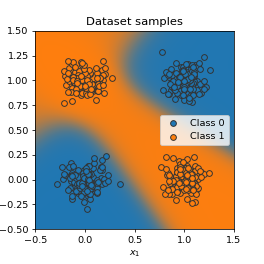

In [71]:
with torch.no_grad():
    data = test_dataset.data.cpu().numpy()
    label = test_dataset.label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2) # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = preds * c0[None,None] + (1 - preds) * c1[None,None] # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy() # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='upper', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)

## Zapisywanie i wczytywanie modelu

In [72]:
state_dict = model.state_dict()
print(state_dict)

OrderedDict([('linear1.weight', tensor([[-3.4391,  2.1547],
        [-1.3853,  2.1414],
        [ 2.3884, -3.2747],
        [ 2.2791,  2.4472]], device='cuda:0')), ('linear1.bias', tensor([-0.6307,  0.5509, -0.9835, -0.4581], device='cuda:0')), ('linear2.weight', tensor([[ 4.7776, -1.6308,  3.6980,  3.7094]], device='cuda:0')), ('linear2.bias', tensor([1.6077], device='cuda:0'))])


In [73]:
torch.save(state_dict, "simple_model.tar")

In [74]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("simple_model.tar")

# Create a new model and load the state
new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", model.cpu().state_dict())
print("\nLoaded model\n", new_model.state_dict())

Original model
 OrderedDict([('linear1.weight', tensor([[-3.4391,  2.1547],
        [-1.3853,  2.1414],
        [ 2.3884, -3.2747],
        [ 2.2791,  2.4472]])), ('linear1.bias', tensor([-0.6307,  0.5509, -0.9835, -0.4581])), ('linear2.weight', tensor([[ 4.7776, -1.6308,  3.6980,  3.7094]])), ('linear2.bias', tensor([1.6077]))])

Loaded model
 OrderedDict([('linear1.weight', tensor([[-3.4391,  2.1547],
        [-1.3853,  2.1414],
        [ 2.3884, -3.2747],
        [ 2.2791,  2.4472]])), ('linear1.bias', tensor([-0.6307,  0.5509, -0.9835, -0.4581])), ('linear2.weight', tensor([[ 4.7776, -1.6308,  3.6980,  3.7094]])), ('linear2.bias', tensor([1.6077]))])


## Zrób to sam:

Spróbujmy przewidzieć ocenę wina na podstawie jego parametrów

In [10]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")

In [11]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


#### ... Jakieś wstępne przetwarzanie danych?

In [12]:
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)
test

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.100000,6
17,6.2,0.66,0.48,1.2,0.029,29.0,75.0,0.98920,3.33,0.39,12.800000,8
18,7.4,0.34,0.42,1.1,0.033,17.0,171.0,0.99170,3.12,0.53,11.300000,6
19,6.5,0.31,0.14,7.5,0.044,34.0,133.0,0.99550,3.22,0.50,9.500000,5
37,7.0,0.33,0.32,1.2,0.053,38.0,138.0,0.99060,3.13,0.28,11.200000,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4864,6.0,0.41,0.23,1.1,0.066,22.0,148.0,0.99266,3.30,0.47,9.633333,5
4874,5.6,0.20,0.36,2.5,0.048,16.0,125.0,0.99282,3.49,0.49,10.000000,6
4878,6.2,0.53,0.02,0.9,0.035,6.0,81.0,0.99234,3.24,0.35,9.500000,4
4884,6.5,0.33,0.38,8.3,0.048,68.0,174.0,0.99492,3.14,0.50,9.600000,5


In [13]:
train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3699,7.6,0.30,0.37,1.60,0.087,27.0,177.0,0.99438,3.09,0.50,9.8,5
1261,7.3,0.19,0.68,1.50,0.050,31.0,156.0,0.99460,3.32,0.64,9.4,6
3483,6.1,0.36,0.26,8.15,0.035,14.0,88.0,0.99031,3.06,0.27,13.0,7
1335,5.7,0.21,0.24,2.30,0.047,60.0,189.0,0.99500,3.65,0.72,10.1,6
88,7.1,0.43,0.61,11.80,0.045,54.0,155.0,0.99740,3.11,0.45,8.7,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1955,6.4,0.29,0.28,11.10,0.063,66.0,169.0,0.99730,2.89,0.57,9.0,5
4260,6.2,0.36,0.22,5.25,0.038,44.0,145.0,0.99184,3.22,0.40,11.2,6
832,7.3,0.30,0.34,2.70,0.044,34.0,108.0,0.99105,3.36,0.53,12.8,8
1283,8.0,0.45,0.36,8.80,0.026,50.0,151.0,0.99270,3.07,0.25,12.7,8


In [14]:
import torch.utils.data as data

In [47]:
train_dataset = data.TensorDataset(torch.from_numpy(train.values[:,:-1]).float(),torch.from_numpy(train.values[:,-1]).float())
train_data_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [48]:
train_dataset[0][1].unsqueeze(dim=0).shape

torch.Size([1])

In [49]:
class WineClassifier(nn.Module):

    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        # Initialize the modules we need to build the network
        self.linear = nn.Linear(num_inputs, num_outputs)
        
    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear(x)
        return x

In [71]:
# model_wine = WineClassifier(num_inputs=train_dataset[0][0].shape[0], num_outputs=1)
model_wine = SimpleClassifier(num_inputs=train_dataset[0][0].shape[0], num_hidden = 16, num_outputs=1)
model_wine.to(device)
optimizer_wine = torch.optim.SGD(model_wine.parameters(), lr = 1e-5)
loss_f = nn.MSELoss()

In [72]:
model_wine.train() 

# Training loop
for epoch in range(300):
    for data_inputs, data_labels in train_data_loader:
        data_labels = data_labels.unsqueeze(dim=0)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        preds = model_wine(data_inputs)
        preds = preds.unsqueeze(dim=0) # Output is [Batch size, 1], but we want [Batch size]

        loss = loss_f(preds, data_labels)

        optimizer_wine.zero_grad() 
        
        loss.backward()

        optimizer_wine.step()
    if epoch%30==0:
        print(f"Epoch: {epoch}, loss: {loss.item():.3}")

Epoch: 0, loss: 36.0
Epoch: 30, loss: 11.0
Epoch: 60, loss: 2.49
Epoch: 90, loss: 2.13
Epoch: 120, loss: 1.16
Epoch: 150, loss: 1.1
Epoch: 180, loss: 0.274
Epoch: 210, loss: 1.16
Epoch: 240, loss: 0.772
Epoch: 270, loss: 0.514


In [73]:
test_dataset = data.TensorDataset(torch.from_numpy(test.values[:,:-1]).float(),torch.from_numpy(test.values[:,-1]).float())

test_data_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=False)
model_wine.eval() # Set model to eval mode
true_preds, num_preds = 0., 0.

with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in test_data_loader:
        
        # Determine prediction of model on test set inputs
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        data_labels = data_labels.unsqueeze(dim=0)
        preds = model_wine(data_inputs)
        preds = preds.squeeze(dim=1)
        # rounding because only possible values are [3,4,5,6,7,8,9]
        preds = preds.round()
        
        # Keeping records of predictions
        true_preds += (preds == data_labels).sum()
        num_preds += data_labels.shape[0]

acc = true_preds / num_preds
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Accuracy of the model: 42.45%
